# Dekompozycja QR

In [1]:
using LinearAlgebra # Biblioteka potrzebna żeby zwracać R jako macierz górnotrójkątną

# Funkcje pomocnicze
function vectorNorm(vec1, vec2)
    return transpose(vec1)*(vec2)
end

function vecProjection(u, vec)
    return vectorNorm(u, vec)/vectorNorm(u,u) * u
end

function vecNormalize(vec)
    return sqrt(1 / vectorNorm(vec, vec)) * vec
end

# ------------------------------------------------------
#               Algorytm Grama Schmidta
# ------------------------------------------------------

function GramSchmidt(mat)

    baseU = Matrix{Float64}(undef, size(mat, 1), 0)
    baseE = Matrix{Float64}(undef, size(mat, 1), 0)

    # wyliczanie bazy E oraz U
    for i in 1:size(mat, 1)
        u = mat[:, i]
        for j in 1:(i-1)
            u = u - vecProjection(baseU[:, j], mat[:, i])
        end

        baseU = hcat(baseU, u)
        baseE = hcat(baseE, vecNormalize(u))
    end
    
    # wyliczanie macierzy R
    R = Matrix{Float64}(undef, size(mat, 1), size(mat, 1))
    for i in 1:size(mat, 1)
        for j in 1:size(mat, 1)
            R[i, j] = vectorNorm(baseE[:, i], mat[:, j])
        end
    end

    baseE, UpperTriangular(R)
end


GramSchmidt (generic function with 1 method)

In [2]:
# ------------------------------------------------------
#         Zmodyfikowany Algorytm Grama Schmidta
# ------------------------------------------------------

function MGS(mat)
    n = size(mat, 2)
    baseU = [mat[:, i] for i in 1:n]
    
    for i in 1:n
        for j in (i+1):n
            baseU[j] = baseU[j] - vecProjection(baseU[i], baseU[j])
        end
    end
    
    baseE = Matrix{Float64}(undef, n, 0)
    
    for i in 1:n
        baseE = hcat(baseE, vecNormalize(baseU[i]))
    end
    
    return baseE, transpose(baseE)*mat
    
end

t = transpose([12.0 6.0 -4.0; -51.0 167.0 24.0; 4.0 -68.0 -41.0])
q, r = MGS(t)
q*r-t


3×3 Matrix{Float64}:
 -1.77636e-15  -7.10543e-15  1.77636e-15
 -1.77636e-15   0.0          1.42109e-14
  8.88178e-16  -1.42109e-14  7.10543e-15

In [3]:
# Prosta funkcja porównująca macierze
# Zwraca parę liczb: maksymalny i średni błąd macierzy result względem macierzy dest
function CompareMatrix(dest, result)
    maxErr, sumErr = 0, 0
    matSize = size(result, 1)

    for i in 1:matSize
        for j in 1:matSize
            nErr = abs(dest[i, j] - result[i, j])
            sumErr = sumErr + nErr
            maxErr = maxErr > nErr ? maxErr : nErr
        end
    end

    maxErr, sumErr/(matSize*matSize)
end

# Funckja oceniająca jakość algorytmu rozkładu QRalgorithm macierzy mat
# Używa Compare Matrix by określić jak dobrze Q^T Q = Id i QR = mat
function AlgorithmQuality(mat, QRalgoritm; extended = false)
    println("===============================\nQR comparison")
    if extended; println("A = ",mat); end

    q, r =  QRalgoritm(mat)

    id = transpose(q)*q
    em, ea = CompareMatrix(I, id)
    
    println("Q^T*Q-Id performance")
    if extended; println("Q = ",q); end
    if extended; println("Q^T*Q = ", id); end
    println("Average Error: ",ea,"\nMax Error: ",em)

    qr = q*r
    em, ea = CompareMatrix(mat, qr)
    println("QR-M performance")
    if extended; println("R = ",r); end
    if extended; println("QR = ",qr); end
    println("Average Error: ",ea,"\nMax Error: ",em)
    print("\n")
end


AlgorithmQuality (generic function with 1 method)

In [4]:

# Losowa macierz
function RandomMatrix(size, rad)
    R = Matrix{Float64}(undef, size, 0)
    for i in 1:size 
        R = hcat(R, rand(size) * rad .- (rad/2))
        #R = hcat(R, [(j == i) ? Float64(1.0) : (abs(i - j) > 0) ? (i - j)*lambda : Float64(0.0) for j in 1:size]) 
    end
    return R
end 
R = (RandomMatrix(30, 10^10))

#for i in 1:10
#    print(R[:, i], "\n")
#end

AlgorithmQuality(R, GramSchmidt);

QR comparison
Q^T*Q-Id performance
Average Error: 5.3770698786028e-16
Max Error: 2.4693414543461144e-14
QR-M performance
Average Error: 1.140435536702474e-6
Max Error: 2.765655517578125e-5



In [5]:
# ------------------------------------------------------
#               Algorytm Householdera
# ------------------------------------------------------
function Householder(A)
    # rozmiar macierzy
    n = size(A, 2)
    
    # tworzy macierz Householdera ze wzoru
    function Hn(vec)
        vn = vec
        vn[1] -= sqrt(vectorNorm(vec, vec))
        return I - (2*vn*transpose(vn))/(transpose(vn)*vn)
    end
    
    # nakładanie macierzy H na Id, otrzymujemy H'
    function Hpn(mat)
        m = size(mat, 1)
        d = n - m
        res = convert(Matrix{Float64}, I[1:n, 1:n])
        for i in 1:m
            for j in 1:m
                res[d + i, d + j] = mat[i, j]
            end
        end
        return res
    end
    
    Q = I[1:n, 1:n]
    R = A
    # Iterowanie po rzędzach, branie podmacierzy i obliczanie kolejnych Hn
    for i = 1:1:n-1 
        Sub = R[i:n, i:n]
        Hp = Hpn(Hn(Sub[:, 1]))
        R = Hp*R
        Q = Q*Hp
    end
    
    return Q, UpperTriangular(R)
end
t = transpose([12.0 6.0 -4.0; -51.0 167.0 24.0; 4.0 -68.0 -41.0])
q, r = Householder(t)
q*r-t


3×3 Matrix{Float64}:
 0.0  1.42109e-14  1.77636e-15
 0.0  0.0          1.42109e-14
 0.0  0.0          1.42109e-14

In [63]:
#add random noise
function addRandomNoise(M, amount=0.01)
    noise = rand(Float64, size(M))
    noise = noise .* 2 .- 1 
    noise = noise .* amount
    #uniform distribution from -amount to amount
    return M+noise
end

function matNorm(M)
    sum = 0
    for i in M; sum += i; end
    return sum/(size(M, 1)*size(M, 2))
end

function checkChange(M, decomp; verbose = true, noise = true)
    noisy = noise
    if(noisy === true); noisy = addRandomNoise(M); end
    
    if(verbose); println("Total change in arguments ", sum(noisy-M)); end
    q, r = decomp(M)
    qn, rn = decomp(noisy)
    siz = size(M)[1]*size(M)[2]
    
    
    averageChange = (sum(M-q*r)-sum(noisy-qn*rn))/siz
    
    if(verbose)
        println("Total change in Q ", sum(qn-q))
        println("Average change in Q ", sum(qn-q)/siz)
        println("Total change in R ", sum(rn-r))
        println("Average change in R ", sum(rn-r)/siz)
        println("|ΔQ|/|Δarg| ", sum(qn-q)/sum(noisy-M))
        println("|Δq|/|Δarg| ", sum(qn-q)/(siz*sum(noisy-M)))
        println("|ΔR|/|Δarg| ", sum(rn-r)/sum(noisy-M))
        println("|Δr|/|Δarg| ", sum(rn-r)/(siz*sum(noisy-M)))
        println("Total change in M-Q*R ", sum(M-q*r)-sum(noisy-qn*rn))
        println("Average change in M-Q*R ", averageChange)
    end
    
    return matNorm(M - q*r - noisy + qn*rn)

end

checkChange(t, Householder)


Total change in arguments -0.002743940775655318
Total change in Q -1.636875711136243e-5
Average change in Q -1.8187507901513812e-6
Total change in R -0.0009941328859177645
Average change in R -0.00011045920954641828
|ΔQ|/|Δarg| 0.0059654192454110765
|Δq|/|Δarg| 0.0006628243606012307
|ΔR|/|Δarg| 0.3623011453956553
|Δr|/|Δarg| 0.040255682821739476
Total change in M-Q*R -8.43769498715119e-14
Average change in M-Q*R -9.37521665239021e-15


-9.37521665239021e-15

In [64]:
function solveLinearSystem(M, ys, decomp=GramSchmidt)
    q, r = decomp(M)
    
    ys = transpose(q)*transpose(ys)
    
    solutions = zeros(Float64, size(ys))
    n = size(ys)[1]

    for i in n:-1:1
        sub = 0
        for j in n:-1:i+1
            sub += solutions[j]*r[i,j]
        end
        solutions[i]=(ys[i]-sub)/r[i,i]
    end
    
    #x = r\ys for debug purposes only
    return solutions
end

coeffs = [2.0 3.0; 1.0 4.0]
ys = [7 5]
println(solveLinearSystem(coeffs, ys))
println(solveLinearSystem(coeffs, ys, MGS))
println(solveLinearSystem(coeffs, ys, Householder))

[2.5999999999999996; 0.6000000000000001;;]
[2.5999999999999996; 0.6000000000000001;;]
[2.6000000000000005; 0.5999999999999996;;]


In [65]:

using Plots


function StabilityRace(len, startRange, noise)
    
    t = RandomMatrix(10, startRange)
    org = t
    perturb = addRandomNoise(t, noise)
    
    xs, ys, zs = [], [], []
    
    for i in 1:len
        push!(xs, checkChange(t, GramSchmidt; verbose = false, noise = perturb))
        push!(ys, checkChange(t, MGS;         verbose = false, noise = perturb))
        push!(zs, checkChange(t, Householder; verbose = false, noise = perturb))
        
        t = perturb
        perturb = addRandomNoise(t, noise)
    end
    
    range = collect(1:len)
    
    plot(range, log10.(abs.(xs)), title="Stabilność numeryczne - rzędy błędów", xlabel="numer iteracji", label ="Gram-Schmidt")
    plot!(range, log10.(abs.(ys)), label ="MGS")
    plot!(range, log10.(abs.(zs)), label ="Householder")

end

StabilityRace (generic function with 1 method)

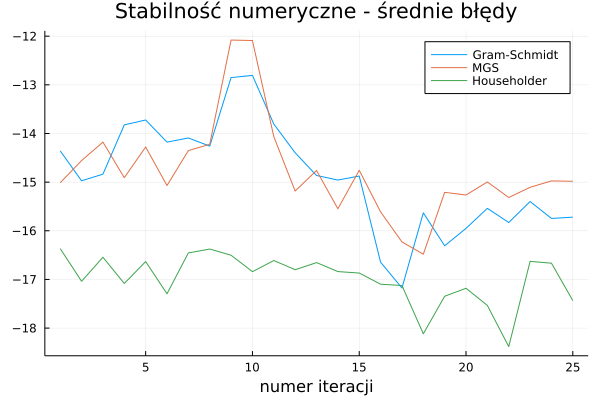

In [92]:
StabilityRace(25, 1, 0.001)

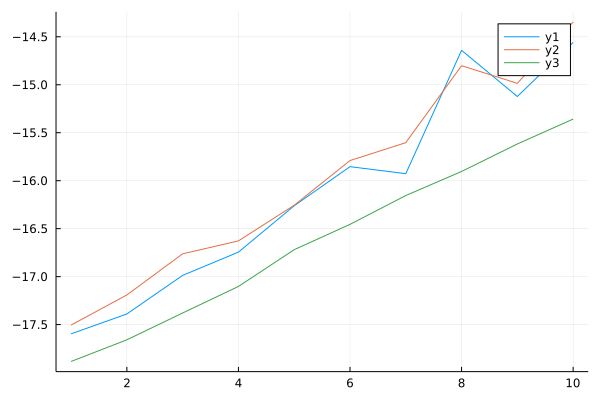

In [147]:

function RandomRadiusRace(rad, it, tests)
    xs, ys, zs = [], [], []
    
    for i in 1:it
        push!(xs, 0)
        push!(ys, 0)
        push!(zs, 0)
        
        for j in 1:tests
            t = RandomMatrix(10, rad)
            
            Q, R = GramSchmidt(t)
            xs[i] += abs(sum(t - Q*R))
            
            Q, R = MGS(t)
            ys[i] += abs(sum(t - Q*R))
            
            Q, R = Householder(t)
            zs[i] += abs(sum(t - Q*R))
        end
        
        rad *= 2;
    end
    
    range = collect(1:it)
    
    plot(range,  log10.(xs ./ tests))
    plot!(range, log10.(ys ./ tests))
    plot!(range, log10.(zs ./ tests))
end
    
RandomRadiusRace(0.001, 10, 100)

9